In [1]:
import pandas as pd 
import glob
import numpy as np 
import matplotlib.pyplot as plt
from osgeo import gdal
from scipy import constants 

### Get data


In [2]:
inst8_fp = r'/home/broberts-pierel/Documents/intercalibration/data/inst8/'
vnir_cal = r'/home/broberts-pierel/shared_drive/AK_snow/intercalibration_experiment/data/inst8/VNIR_1800_SN00812_Plane_1x_2023-06-30T160205.set'
swir_cal = r'/home/broberts-pierel/shared_drive/AK_snow/intercalibration_experiment/data/inst8/SWIR_384me_SN3107_Plane_2023-06-07T151103.set'


### Define functions

In [3]:
def read_inst8_data(input_dir, search_term='', sensor=''): 
    """
    Read in data from the HySpex instrument (a VNIR and SWIR sensor).

    The data are organized as files for the SPHERE, Ar, and Hg, and are split into VNIR and SWIR files because they are two different physical sensors.

    Parameters
    ----------
    input_dir : str
        Filepath to the directory where the raw HySpex files are located.
    search_term : str
        A substring used to identify a measurement type, e.g., 'sphere' or 'SPHERE' for measurements taken of the integrating sphere.
    sensor : str 
        The name of a sensor from Hyspex. Appropriate args are VNIR and SWIR. 
    Returns
    -------
    Tuple
        Returns a tuple of image array, wavelengths and the filepath (str)
    """
    # Get the image files 
    img_fps = glob.glob(input_dir+f'*{sensor}*{search_term}*.hyspex')[0]

    # Register the gdal driver for things with an .hdr file
    gdal.GetDriverByName('EHdr').Register()

    img = gdal.Open(img_fps)

    # Get the center wavelengths
    wavelengths = img.GetMetadata().values()

    # Extract just the band center wavelength as a float 
    wavelengths = [float(i.split(' ')[0]) for i in list(wavelengths)[1:]]

    bands = []
    for b in range(1,len(wavelengths)+1): 
        band = img.GetRasterBand(b)
        data = band.ReadAsArray()
        bands.append(data)
    
    # Take all bands and stack them to 3d
    out = np.stack(bands,axis=2)
    
    # Return an array of the wavelengths for plotting
    return out, np.array(wavelengths), img_fps


In [4]:
def extract_calib_values(file_path, search_term):
    """
    Use to read the Hyspex .set files. 
    Paramaters: 
    ----------
    file_path : str 
        The path to a Hyspex .set file for the sensor you're interested in. 
    search_term : str
        A substring used to identify a measurement type, e.g., 'sphere' or 'SPHERE' for measurements taken of the integrating sphere.
    Returns
    -------
        Numpy array of the paramater you're looking for or returns None
    """
    
    output_ls = []

    with open(file_path, 'r') as file:

        lines = file.readlines()

        start_index = [l for l in range(len(lines)) if lines[l].startswith(search_term)]
        
        if len(start_index) != 1: 
            return None 
        else: 
            start_index = start_index[0]

        for line in lines[start_index+1:]:    
            try: 
                output_ls.append(float(line))
            except ValueError: 
                return np.array(output_ls)

In [7]:
def calibrate_inst8(input_data, calib_file, **kwargs): 
    """
    Perform the actual calibration/conversion from raw Hyspex DN to radiance. 
    Paramaters: 
    ----------
    input_data : array 
        A numpy array of the input image data  
    calib_file : str
        A filepath to the .set file for the sensor you're working with. 
    kwargs : dict 
        A dictionary containing the variables required to perform the calibration. 
    Returns
    -------
        Numpy array of calibrated radiance 
    
    """

    # Get some variables 
    # NOTE this is still coming from the .set file, we can take from raw but it shouldn't change very much or at all
    spec_calib = extract_calib_values(calib_file, 'spectral_calib =')

    # Get the calibration arrays 
    RE = kwargs['RE']
    QE = kwargs['QE']
    BG = kwargs['background']
    BG = np.swapaxes(BG, 0,1)
    
    pixel_x = kwargs['pixelSizeX']
    pixel_y = kwargs['pixelSizeY']
   
    # Set a few more variables 
    SF = kwargs['SF']
    integration_time = kwargs[f'integrationTime']
    aperature = kwargs['apertureSize']
    aperture_area = np.pi*aperature*aperature 

    rows = input_data.shape[0]
    cols = input_data.shape[1]
    bands = input_data.shape[2]

    # Reshape the calibration vals so the math works 
    spec_calib = np.diff(spec_calib)
    spec_calib = np.append(spec_calib, spec_calib[-1])
    spec_calib = [np.full((rows,cols), a) for a in spec_calib]
    spec_calib = np.stack(spec_calib, axis=2)

    RE = np.reshape(RE, (cols, bands))
    RE = np.repeat(RE[np.newaxis, :, :], rows, axis=0)
    
    QE = [np.full((rows,cols), a) for a in QE]
    QE = np.stack(QE, axis=2)

    BG = np.repeat(BG[np.newaxis, :, :], rows, axis=0)

    # NOTE this is not how we would normally calculate this but its setup in the Github repo and contributes to a 'correct' looking curve
    omega =  pixel_x * pixel_y
   
    wavelengths_arr = [np.full((rows, cols), a) for a in kwargs['wavelengths_nm']]
    wavelengths_arr = np.stack(wavelengths_arr, axis = 2)

    # From: https://github.com/EnSpec/hypro-dev/blob/main/hypro/Radiometry.py
    gain = constants.h*constants.c*1e6/(RE*QE*SF*integration_time*aperture_area*omega*spec_calib*wavelengths_arr)*100.0 # shape=(bands, samples); 100.0 to convert radiance to mW/(cm2*um*sr).
    
    # Calculate the radiance - from above github link 
    L = (input_data-BG)*gain

    return L


In [8]:
def read_inst8_bytes(hyp_fp): 
    """
    Given the Hyspex raw file, read the binary header and get the information we need to do calibration. NOTE that 
    this code comes directly from: https://github.com/EnSpec/hypro-dev/blob/main/hypro/Radiometry.py. 
    
    Paramaters: 
    ----------
    hyp_fp : str
        A filepath to the raw DN hypsex file you're going to calibrate. 
    Returns
    -------
        A dictionary of values required to do the calibration. 
    
    """
    header = dict()
   
    fid = open(hyp_fp, 'rb')

    header['word'] = np.fromfile(fid, dtype=np.int8, count=8)
    header['hdrSize'] = np.fromfile(fid, dtype=np.int32, count=1)[0]
    header['serialNumber'] = np.fromfile(fid, dtype=np.int32, count=1)[0]
    header['configFile'] = np.fromfile(fid, dtype=np.int8, count=200)
    header['settingFile'] = np.fromfile(fid, dtype=np.int8, count=120)

    header['scalingFactor'] = np.fromfile(fid, dtype=np.float64, count=1)[0]
    header['electronics'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['comsettingsElectronics'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['comportElectronics'] = np.fromfile(fid, dtype=np.int8, count=44)
    header['fanSpeed'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]

    header['backTemperature'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['Pback'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['Iback'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['Dback'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['comport'] = np.fromfile(fid, dtype=np.int8, count=64)

    header['detectstring'] = np.fromfile(fid, dtype=np.int8, count=200)
    header['sensor'] = np.fromfile(fid, dtype=np.int8, count=176)
    header['temperature_end'] = np.fromfile(fid, dtype=np.float64, count=1)[0]
    header['temperature_start'] = np.fromfile(fid, dtype=np.float64, count=1)[0]
    header['temperature_calibration'] = np.fromfile(fid, dtype=np.float64, count=1)[0]

    header['framegrabber'] = np.fromfile(fid, dtype=np.int8, count=200)
    header['ID'] = np.fromfile(fid, dtype=np.int8, count=200)
    header['supplier'] = np.fromfile(fid, dtype=np.int8, count=200)
    header['leftGain'] = np.fromfile(fid, dtype=np.int8, count=32)
    header['rightGain'] = np.fromfile(fid, dtype=np.int8, count=32)

    header['comment'] = np.fromfile(fid, dtype=np.int8, count=200)
    header['backgroundFile'] = np.fromfile(fid, dtype=np.int8, count=200)
    header['recordHD'] = np.fromfile(fid, dtype=np.int8, count=1)
    header['unknownPOINTER'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['serverIndex'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]

    header['comsettings'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['numberOfBackground'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['spectralSize'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['spatialSize'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['binning'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]

    header['detected'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['integrationTime'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['frameperiod'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['defaultR'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['defaultG'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]

    header['defaultB'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['bitshift'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['temperatureOffset'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['shutter'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['backgroundPresent'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]

    header['power'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['current'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['bias'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['bandwidth'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['vin'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]

    header['vref'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['sensorVin'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['sensorVref'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['coolingTemperature'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['windowStart'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]

    header['windowStop'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['readoutTime'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['p'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['i'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['d'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]

    header['numberOfFrames'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['nobp'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['dw'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['EQ'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['lens'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]

    header['FOVexp'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['scanningMode'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['calibAvailable'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['numberOfAvg'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['SF'] = np.fromfile(fid, dtype=np.float64, count=1)[0]

    header['apertureSize'] = np.fromfile(fid, dtype=np.float64, count=1)[0]
    header['pixelSizeX'] = np.fromfile(fid, dtype=np.float64, count=1)[0]
    header['pixelSizeY'] = np.fromfile(fid, dtype=np.float64, count=1)[0]
    header['temperature'] = np.fromfile(fid, dtype=np.float64, count=1)[0]
    header['maxFramerate'] = np.fromfile(fid, dtype=np.float64, count=1)[0]

    header['spectralCalibPOINTER'] = np.fromfile(fid, dtype=np.int32, count=1)[0]
    header['REPOINTER'] = np.fromfile(fid, dtype=np.int32, count=1)[0]
    header['QEPOINTER'] = np.fromfile(fid, dtype=np.int32, count=1)[0]
    header['backgroundPOINTER'] = np.fromfile(fid, dtype=np.int32, count=1)[0]
    header['badPixelsPOINTER'] = np.fromfile(fid, dtype=np.int32, count=1)[0]

    header['imageFormat'] = np.fromfile(fid, dtype=np.uint32, count=1)[0]
    header['spectralVector'] = np.fromfile(fid, dtype=np.float64, count=header['spectralSize'])
    header['QE'] = np.fromfile(fid, dtype=np.float64, count=header['spectralSize'])
    header['RE'] = np.fromfile(fid, dtype=np.float64, count=header['spectralSize']*header['spatialSize'])
    # header['RE'].shape = (header['spectralSize'], header['spatialSize'])
    header['background'] = np.fromfile(fid, dtype=np.float64, count=header['spectralSize']*header['spatialSize'])
    header['background'].shape = (header['spectralSize'], header['spatialSize'])

    header['badPixels'] = np.fromfile(fid, dtype=np.uint32, count=header['nobp'])
    if header['serialNumber']>=3000 and header['serialNumber']<=5000:
        header['backgroundLast'] = np.fromfile(fid, dtype=np.float64, count=header['spectralSize']*header['spatialSize'])
        header['backgroundLast'].shape = (header['spectralSize'], header['spatialSize'])

    fid.close()

    return header 

### Do Calibration

In [9]:
inst_8_sphere_data_VNIR, wavelengths_VNIR, vnir_img_fp = read_inst8_data(inst8_fp,search_term='SPHERE',sensor='VNIR')
inst_8_sphere_data_SWIR, wavelengths_SWIR, swir_img_fp = read_inst8_data(inst8_fp,search_term='SPHERE',sensor='SWIR')

vnir_bytes = read_inst8_bytes(vnir_img_fp)
swir_bytes = read_inst8_bytes(swir_img_fp)

# Add the wavelength arrays TODO these can just be taken from the existing dict 
vnir_bytes['wavelengths_nm'] = wavelengths_VNIR
swir_bytes['wavelengths_nm'] = wavelengths_SWIR

inst_8_sphere_VNIR_calib = calibrate_inst8(inst_8_sphere_data_VNIR, vnir_cal, **vnir_bytes)
inst_8_sphere_SWIR_calib = calibrate_inst8(inst_8_sphere_data_SWIR, swir_cal, **swir_bytes)

# Make a spectrum - first take the row-wise median
inst8_plot_vnir = np.median(inst_8_sphere_VNIR_calib, axis=0)
inst8_plot_swir = np.median(inst_8_sphere_SWIR_calib, axis=0)

# Then take the col wise median TODO This could also be done before the calibration math, not sure if that would be better
inst8_plot_vnir = np.median(inst8_plot_vnir, axis=0)
inst8_plot_swir = np.median(inst8_plot_swir, axis=0)

# TODO there is some overlap in the VNIR and SWIR bands, the slicing spot here is arbitrary, check if there's a better way
inst8_plot_combined = np.concat([inst8_plot_vnir[:-8], inst8_plot_swir[2:]])
inst8_wavelengths_combined = np.concat([wavelengths_VNIR[:-8], wavelengths_SWIR[2:]])

# Convert from mW/(cm2*um*sr) to W/m2/sr/nm when building the df 
inst8_sphere_dfs = pd.DataFrame({'wavelength_nm':inst8_wavelengths_combined, 'Target':inst8_plot_combined*1e7})

inst8_sphere_dfs['instrument_id'] = 'Inst8'

/home/broberts-pierel/miniforge3/envs/snowex_312/lib/python3.12/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


### Visualize 

Text(0, 0.5, 'Radiance (W/m$^2$/sr$^-1$/nm)')

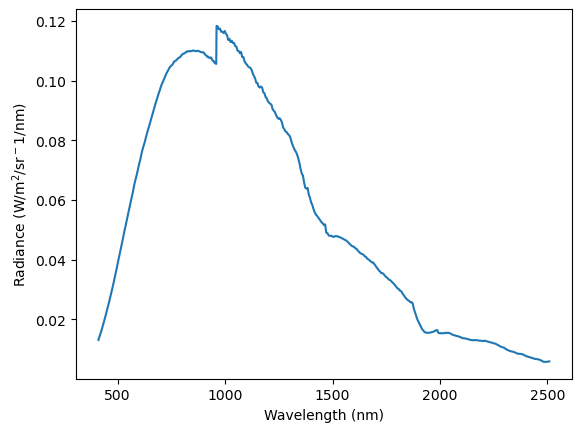

In [11]:
plt.plot(inst8_sphere_dfs['wavelength_nm'], inst8_sphere_dfs['Target'])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Radiance (W/m$^2$/sr$^-1$/nm)')